# Part1

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
df = pd.read_csv("mlb_stats_Batters1.csv")
X = df.drop(columns=['Award_points','Player']).values
y = df['Award_points'].values.reshape(-1,1)
n, p = X.shape
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()

In [ ]:
df.head()

,Player,AB,R,H,2B,3B,HR,RBI,BB,SO,HBP,Award_points
0,Aaron Hicks,200,35,55,7,1,7,31,35,49,0,0
1,Aaron Hicks,69,9,13,2,0,1,5,7,20,0,0
2,Aaron Judge,367,79,98,16,0,37,75,88,130,0,0
3,Abraham Almonte,15,1,1,1,0,0,0,1,8,0,0
4,Abraham Toro,18,4,8,0,0,2,9,2,5,1,0


The data is taken from kaggle,and it is a data of the batting stats of all the players in the MLB in 2023. 
The award points is calculate by some weights time the award each player won in 2023. As the batting stats reflects the abilities of each player well, I try to use HMC to build a model to predict the expected award points or maybe awards that they may get for 2024 season if we get the batting stats of a player in 2024. I am using a MVN model with MVN prior for beta, a truncatednormal prior for sigma.

In [ ]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.106,0.019,-0.144,-0.071,0.001,0.000,1341.0,1428.0,1.0
"betas[0, 1]",-0.106,0.020,-0.142,-0.069,0.000,0.000,1909.0,1510.0,1.0
"betas[0, 2]",-0.105,0.020,-0.145,-0.071,0.000,0.000,2063.0,1472.0,1.0
"betas[0, 3]",-0.106,0.020,-0.142,-0.070,0.001,0.000,1387.0,1464.0,1.0
"betas[0, 4]",-0.105,0.020,-0.142,-0.067,0.001,0.000,1544.0,1193.0,1.0
...,...,...,...,...,...,...,...,...,...
"betas[9, 6]",-0.502,0.149,-0.793,-0.228,0.002,0.002,5306.0,1424.0,1.0
"betas[9, 7]",-0.502,0.149,-0.766,-0.211,0.002,0.002,4960.0,1436.0,1.0
"betas[9, 8]",-0.505,0.143,-0.770,-0.239,0.002,0.002,4645.0,1455.0,1.0
"betas[9, 9]",-0.502,0.145,-0.754,-0.226,0.002,0.002,5372.0,1571.0,1.0


ESS:The effective size for most of the parameter here is larger than 2000, and some of them is about 5000. This shows that the model explored the dataset very well and lead to more reliable statistical estimates and inferences. High ESS values indicate that the samples are informative and less correlated, providing a more robust basis for estimating the posterior distribution.

Divergences: We can know that there are no obivious divergences which indicates that the model is quite good.The absence of divergences is a sign that the model's geometry was well-handled by the sampling algorithm.

Convergence:The r_hat for each of parameter is 1.0 which indicates that the chains have converged to a common distribution.

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

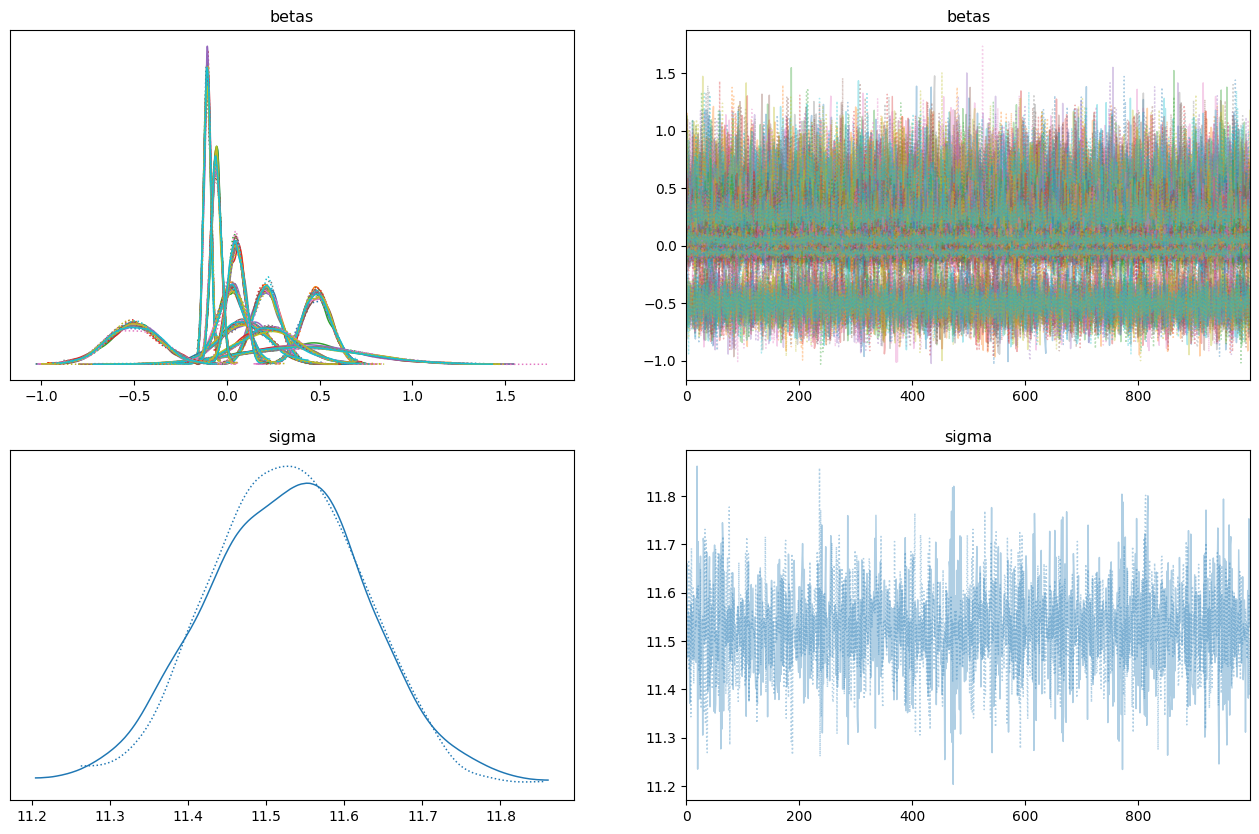

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(16,10))
az.plot_trace(idata, axes=ax)

Mixing:The mixing here is quite good, this means the samples are exploring the posterior distribution effectively. 

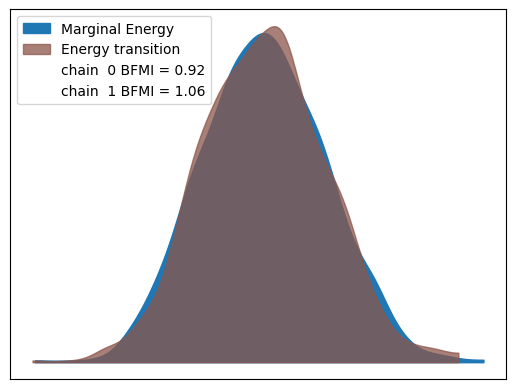

In [ ]:
az.plot_energy(idata)

The plot shows a closer alignment between the energy transition and the marginal energy distribution. The BFMI values are all around 1 for both chains which implies that the algorithm is efficiently exploring the parameter space and sampling from the target distribution.

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (202) in plot_autocorr, generating only 40 plots
  warnings.warn(


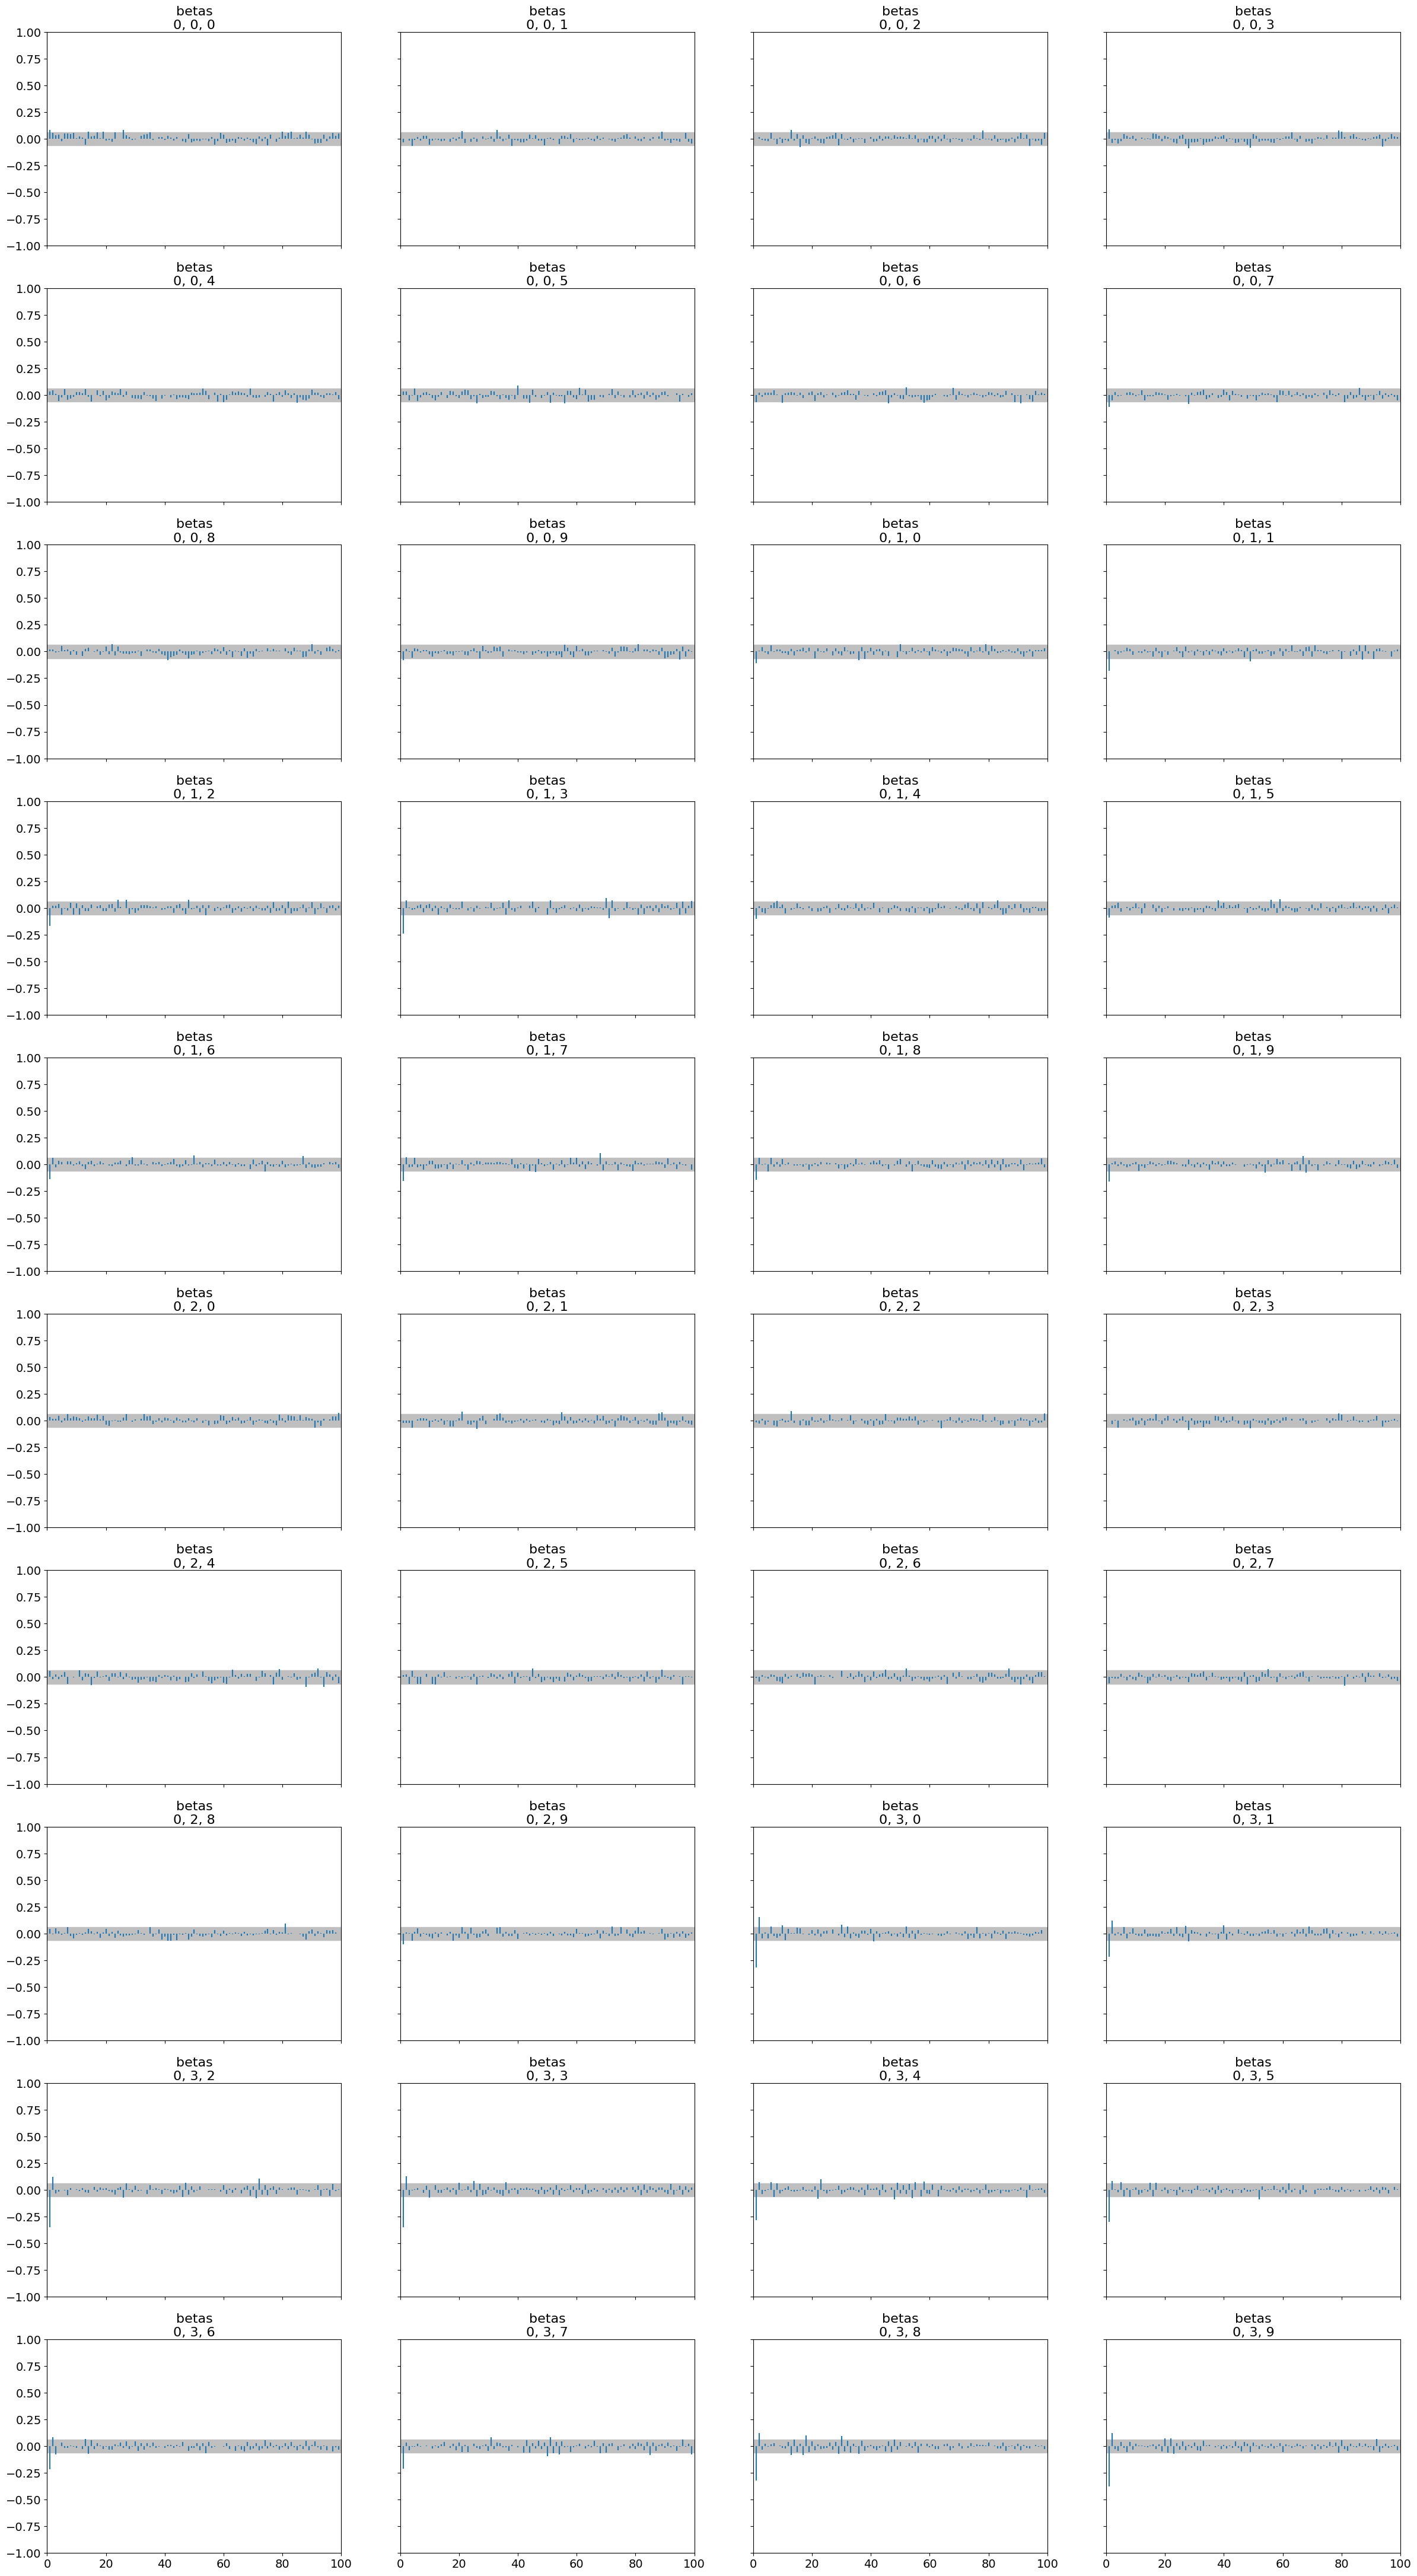

In [ ]:
with MLR:
    az.plot_autocorr(idata)
    plt.show()

Autocorrelation:The autocorrelation for each beta coefficient is around zero. This suggests that there is very little autocorrelation in the samples for these parameters.The low levels of autocorrelation across lags indicate that the sampling chains are mixing well and very effecient.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

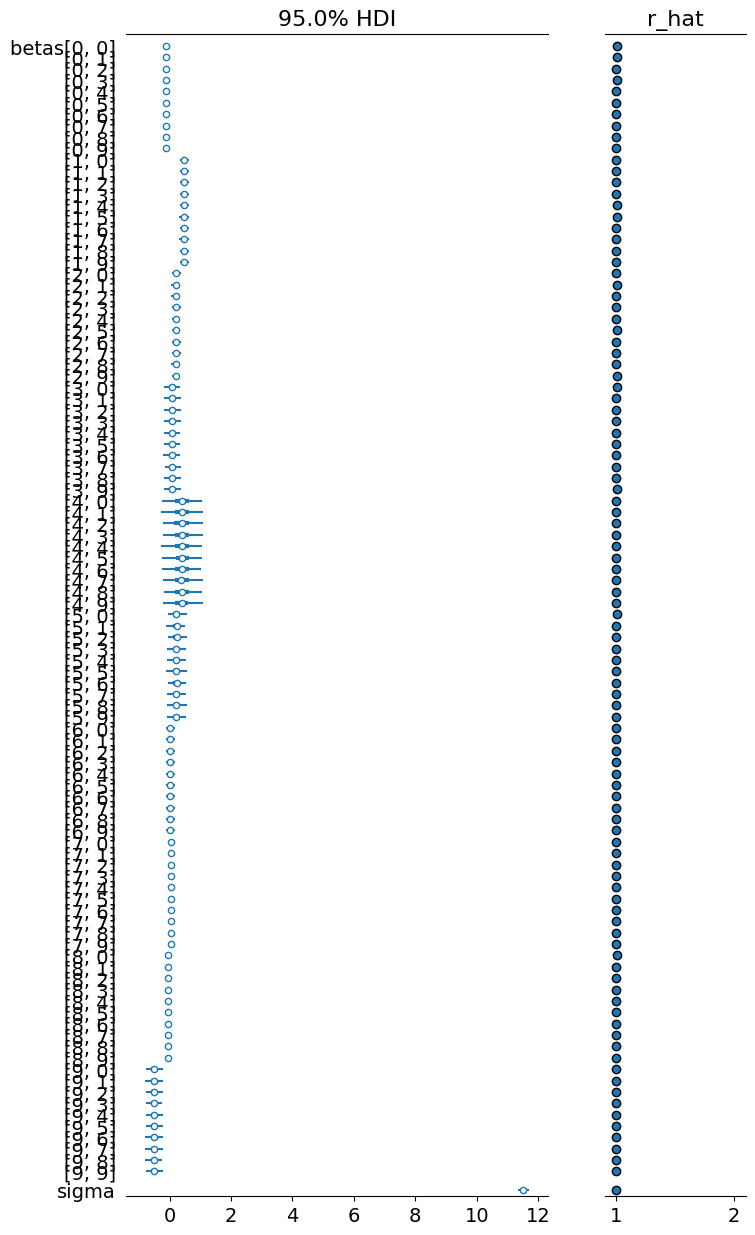

In [ ]:
az.plot_forest(idata, combined=True, hdi_prob=0.95, r_hat=True)

The most important factors here is beta1 and beta4 which have highest positive value. Beta1 is for "R" which means a run and it is counted when the batter reaches home plate, either by their own work (a home run) or by the work of another batter. And it is kind of surprising as we always thinks hits("h", when the batter reaches at least first base in their at bat) reflects more about its batting ability and may get more awards. I think the reason for that maybe is I count team awards in awards point. More run will help whole team get more score and more wins. Beta4 is "3B" which is triple. A triple occurs when a batter hits the ball into play and reaches third base. The reason for triple have high beta value is triple is kind of rare in matchs and player don't have that much of triple as hit.

# Part2

1.
$p(\beta |\sigma, X,y)=((\sigma^{-2}{X}^\top  y + \sigma_\beta^{-2}\beta_0)^{-1}([\sigma^{-2}{X}^\top  X]^{-1}+\sigma_\beta^{-2}I),[\sigma^{-2}{X}^\top  X]^{-1}+\sigma_\beta^{-2}I)$

2.
 $E[\beta |\sigma, X,y]= (\sigma^{-2}{X}^\top  y + \sigma_\beta^{-2}\beta_0)^{-1}([\sigma^{-2}{X}^\top  X]^{-1}+\sigma_\beta^{-2}I)$ 

3.
$\sigma = 1$,$\beta_0 = 0$,$\sigma_\beta = 1$

4.
$\sigma = 1$,$\beta_0 = 0$,$\sigma_\beta = 1$

5.
$Var[\beta |\sigma, X,y]=[\sigma^{-2}{X}^\top  X]^{-1}+\sigma_\beta^{-2}I$

# Part3

In [10]:
from scipy import stats
Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p);
    y = pm.MvNormal('y', mu=mu, chol=L, observed=y)

with MNV_LKJ:
    idata1 = pm.sample()

In [11]:
az.summary(idata1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.003,0.016,-0.027,0.031,0.000,0.000,1850.0,1178.0,1.0
mu[1],0.046,0.039,-0.033,0.118,0.001,0.001,1015.0,1417.0,1.0
mu[2],-0.001,0.066,-0.134,0.118,0.002,0.002,948.0,1200.0,1.0
mu[3],-0.019,0.016,-0.051,0.007,0.000,0.000,2430.0,1472.0,1.0
mu[4],0.070,0.027,0.022,0.125,0.001,0.000,2545.0,1630.0,1.0
...,...,...,...,...,...,...,...,...,...
packed_L[50],-0.161,0.011,-0.182,-0.141,0.000,0.000,2529.0,1527.0,1.0
packed_L[51],-0.055,0.010,-0.074,-0.035,0.000,0.000,2194.0,1305.0,1.0
packed_L[52],0.089,0.010,0.071,0.110,0.000,0.000,2604.0,1720.0,1.0
packed_L[53],-0.015,0.010,-0.033,0.004,0.000,0.000,2787.0,1484.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>]], dtype=object)

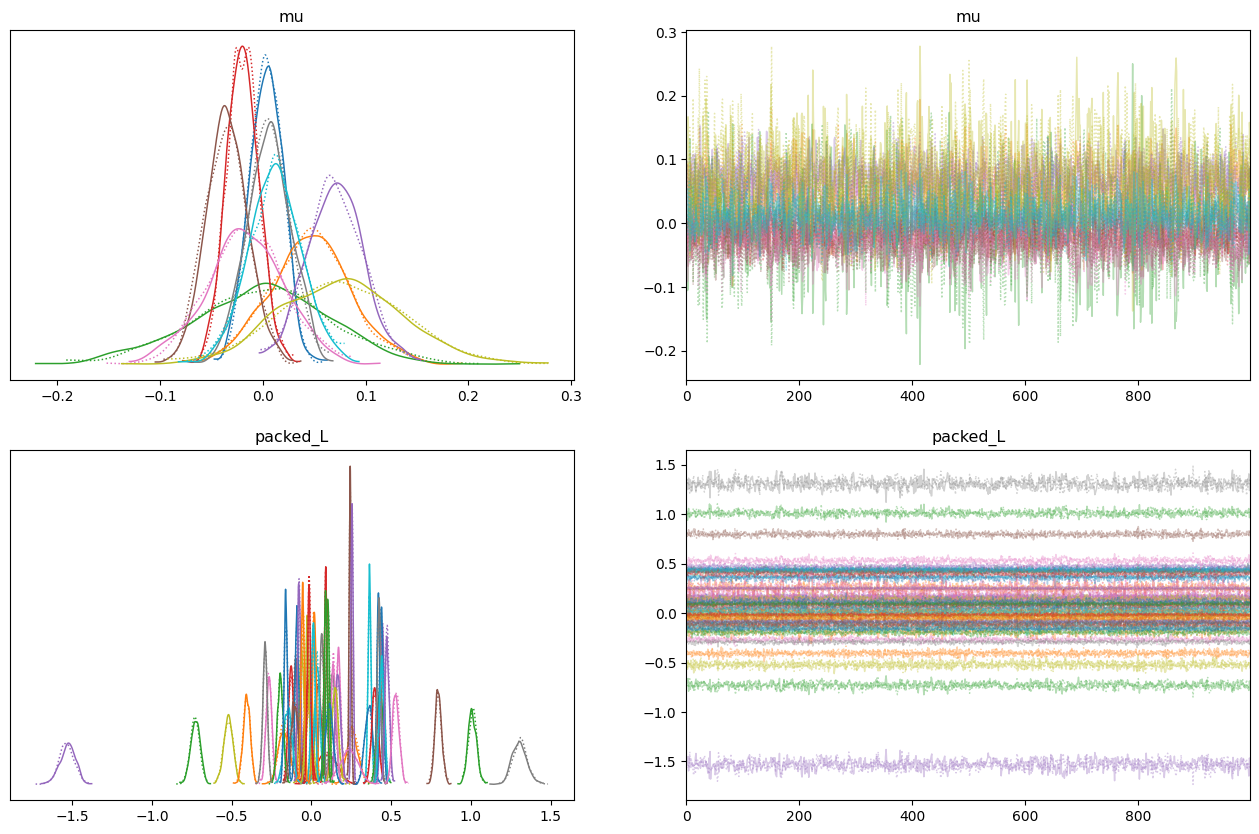

In [12]:
fig,ax = plt.subplots(2,2, figsize=(16,10))
az.plot_trace(idata1, axes=ax)

<Axes: >

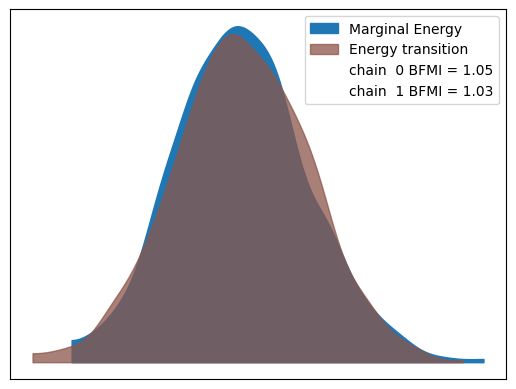

In [14]:
az.plot_energy(idata1)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

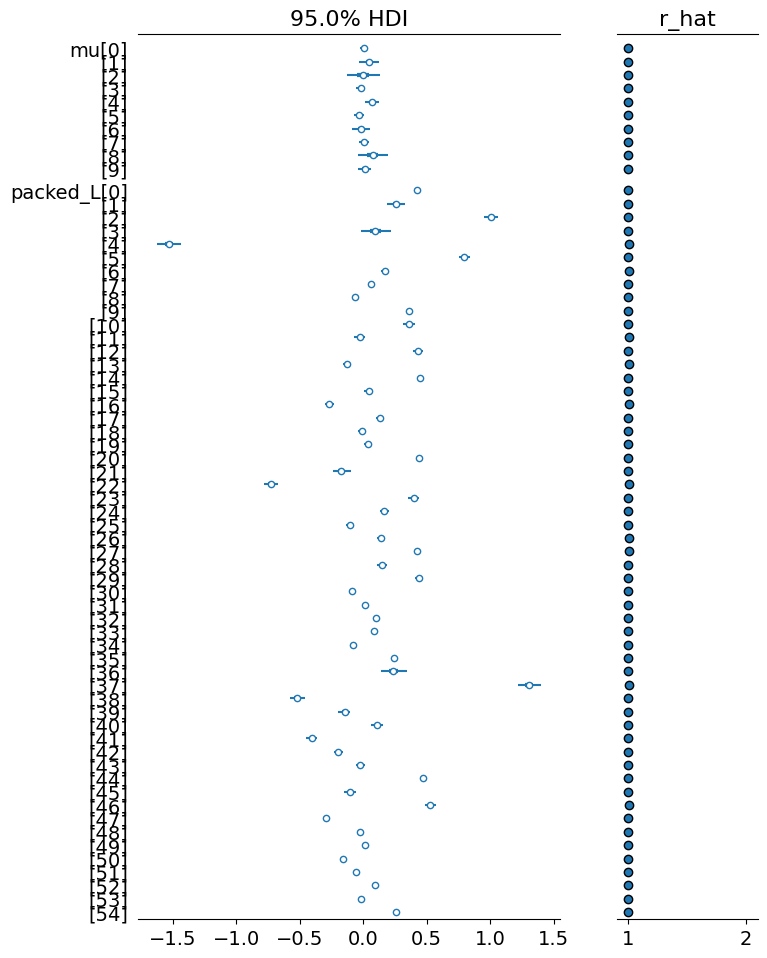

In [15]:
az.plot_forest(idata1, combined=True, hdi_prob=0.95, r_hat=True)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (130) in plot_autocorr, generating only 40 plots
  warnings.warn(


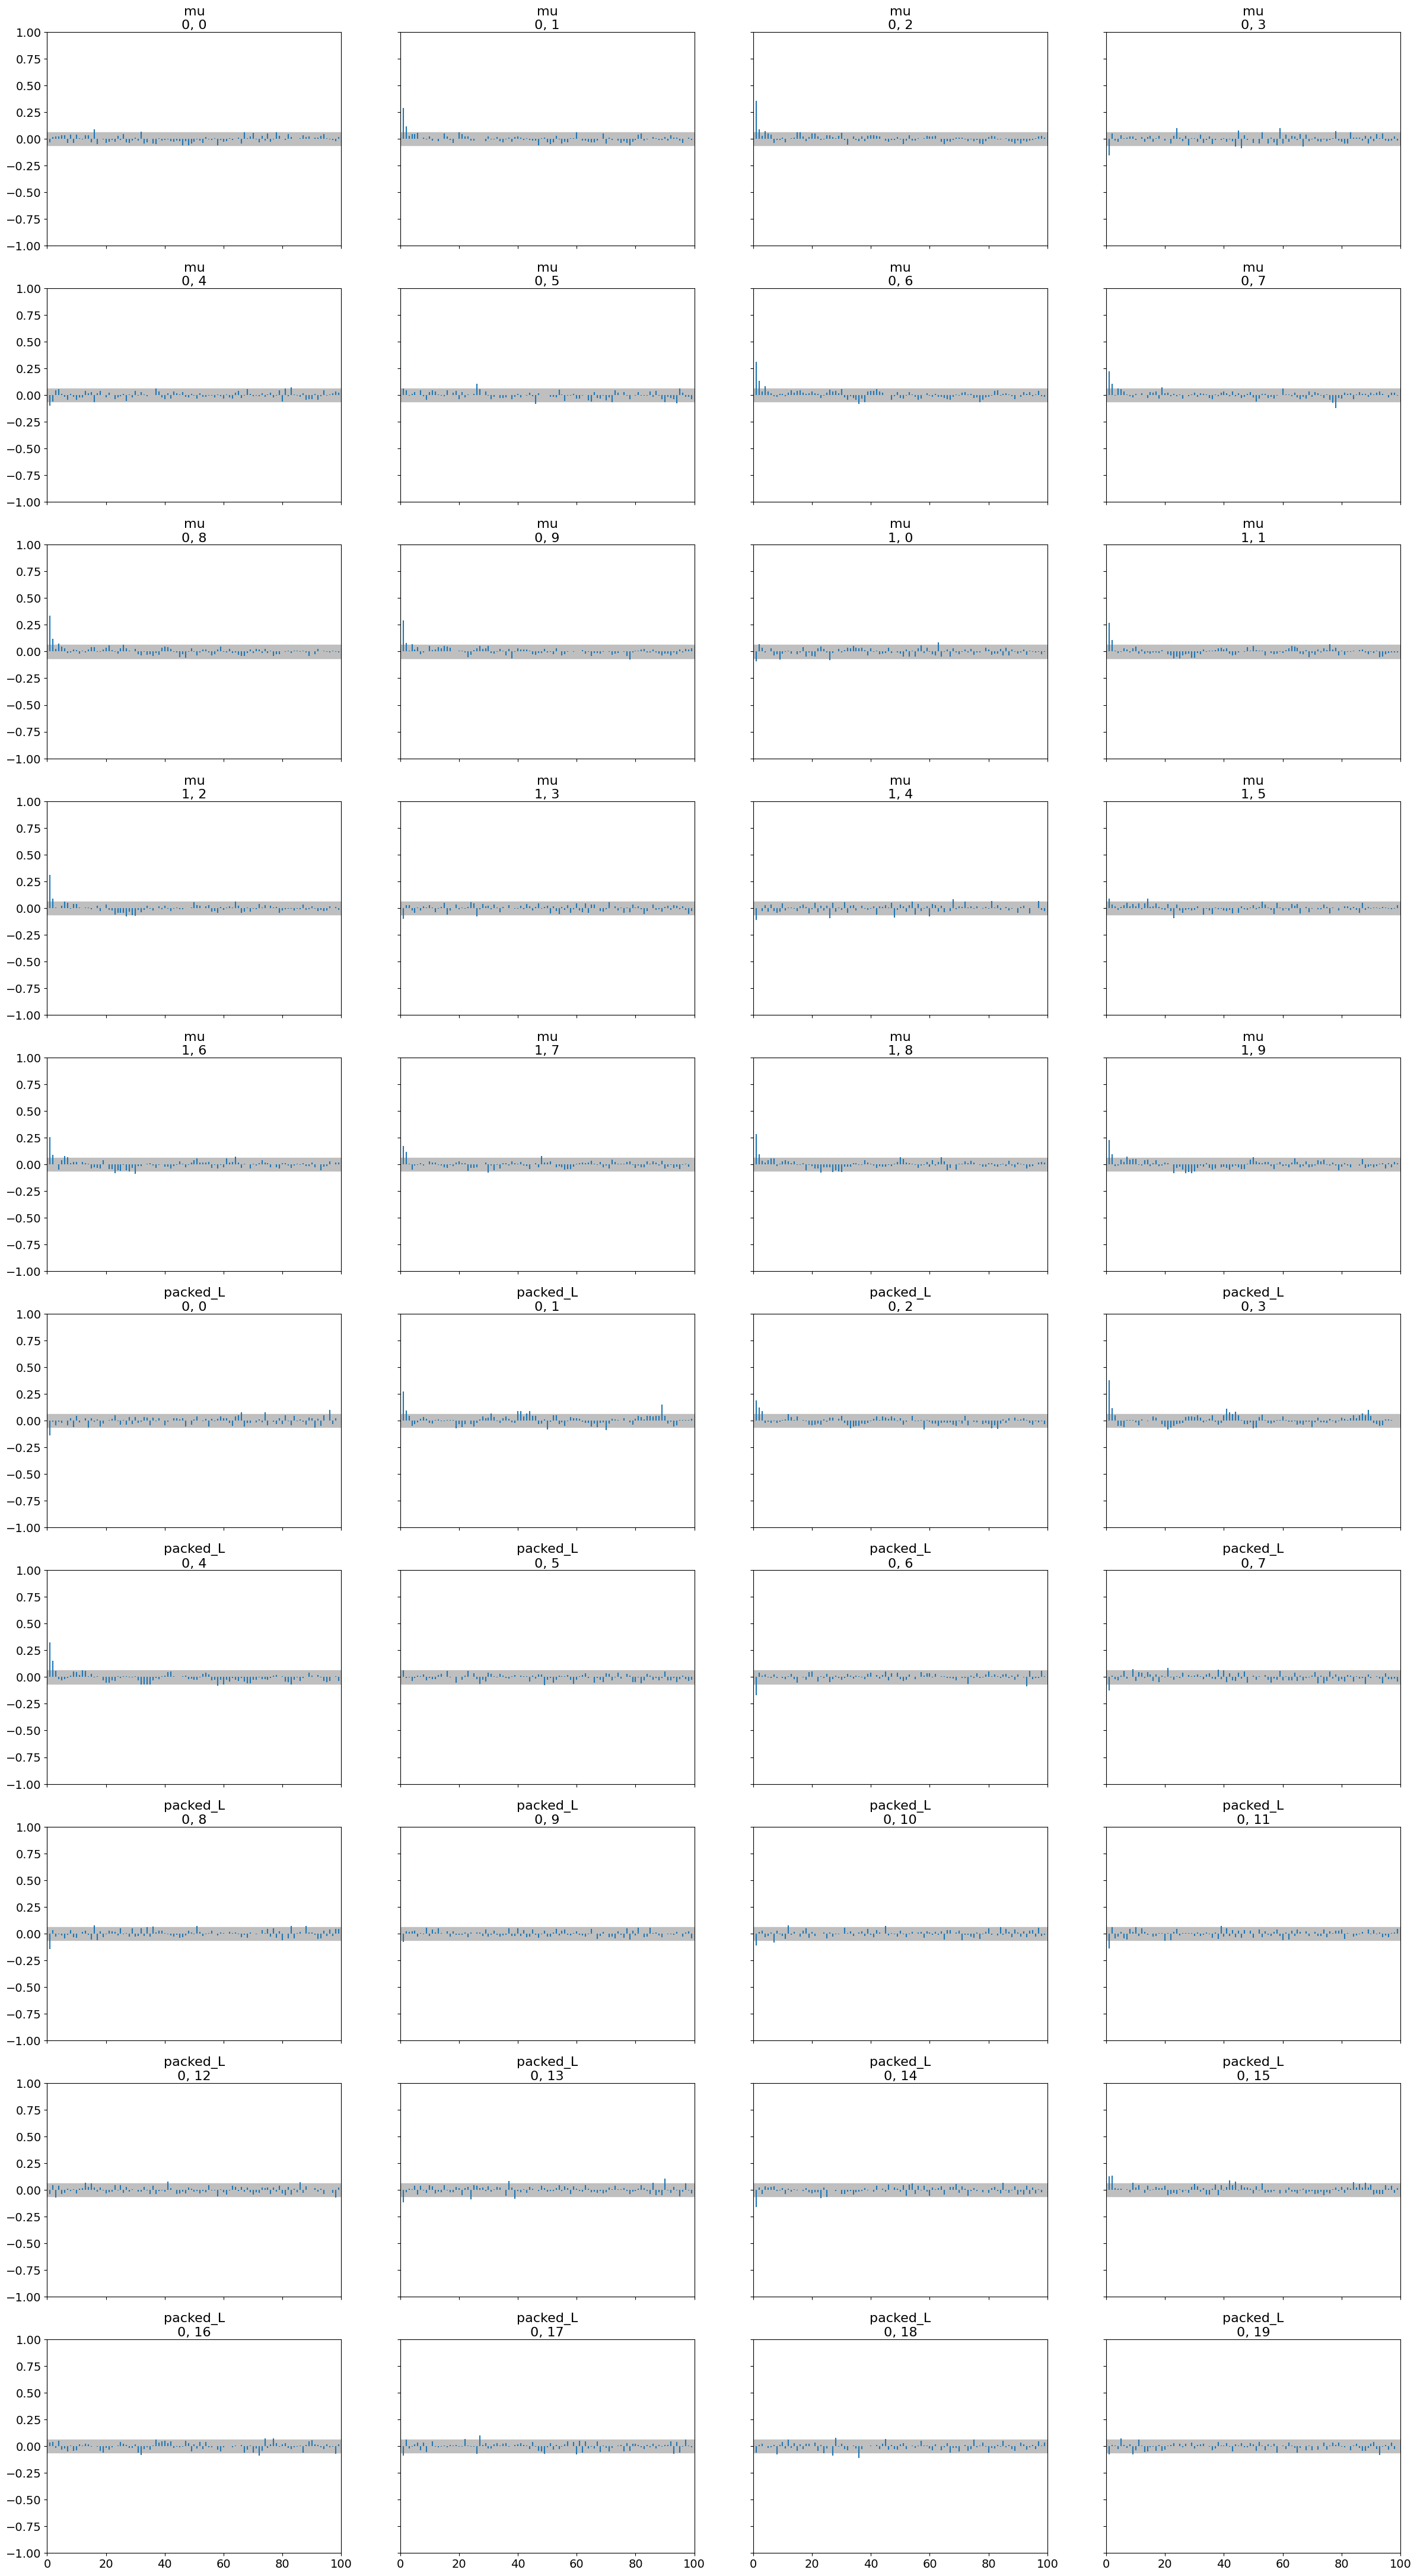

In [16]:
with MNV_LKJ:
    az.plot_autocorr(idata1)
    plt.show()